In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# Martian Frost HiRISE Image Classification
* Data confidence weighting
* Predicts frost_context probabilities

Outside of built-in python 3 libraries, this code uses numpy, skimage, tqdm, PIL, matplotlib, and tensorflow.

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

# Suggested Data Split

Use the suggested train/val/test split to avoid data leakage across each data subset from a geospatial perspective.

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./splits/train_source_images.txt')
validate_ids = load_text_ids('./splits/val_source_images.txt')
test_ids = load_text_ids('./splits/test_source_images.txt')

## Create frost context array helper functions
These will help us decode and encode the frost context arrays that are stored in the jsons.
Will also be used for data visualization

In [4]:
# [defrosting marks, halos, polygonal cracks, slab ice cracks, uniform albedo, other]
# convert string to index
def get_context_idx(str):
    if (str == 'defrosting_marks'):
        return 0
    elif (str == 'halos'):
        return 1
    elif (str == 'polygonal_cracks'):
        return 2
    elif (str == 'slab_ice_cracks'):
        return 3
    elif (str == 'uniform_albedo'):
        return 4
    elif (str == 'other'):
        return 5
    
# convert annotations to frost context entry
def get_category_format(data):
    entry = [0, 0, 0, 0, 0, 0]
    for k in range(len(data['frost_types'])):
        if data['frost_types'][k] == 'defrosting_marks':
            entry[0] = 1
        elif data['frost_types'][k] == 'halos':
            entry[1] = 1
        elif data['frost_types'][k] == 'polygonal_cracks':
            entry[2] = 1
        elif data['frost_types'][k] == 'slab_ice_cracks':
            entry[3] = 1
        elif data['frost_types'][k] == 'uniform_albedo':
            entry[4] = 1
        elif data['frost_types'][k] == 'other':
            entry[5] = 1
    return entry

# convert frost context entry to sentence for readability
def decode_array_to_context(arr):
    context = ''
    if arr[0] == 1:
        context += 'defrosting marks, '
    if arr[1] == 1:
        context += 'halos, '
    if arr[2] == 1:
        context += 'polygonal cracks, '
    if arr[3] == 1:
        context += 'slab ice cracks, '
    if arr[4] == 1:
        context += 'uniform albedo, '
    if arr[5] == 1:
        context += 'other, '
    # Remove the last 2 characters from the string
    context = context[:-2]
    if context == '':
        context = 'no frost'
    return context


def get_pred_format(arr):
    context = ''
    if arr[0] != 0:
        context += f'defrosting marks: {np.round(arr[0]*100)}%\n'
    if arr[1] != 0:
        context += f'halos: {np.round(arr[1]*100)}%\n'
    if arr[2] != 0:
        context += f'polygonal cracks: {np.round(arr[2]*100)}%\n'
    if arr[3] != 0:
        context += f'slab ice cracks: {np.round(arr[3]*100)}%\n'
    if arr[4] != 0:
        context += f'uniform albedo: {np.round(arr[4]*100)}%\n'
    if arr[5] != 0:
        context += f'other: {np.round(arr[5]*100)}%\n'
    # Remove the last newline from string
    if context == '':
        context = 'no frost (~0%)\n'
    context = context[:-1]
    return context


## Prepare data as numpy arrays

Load the data and pair a tile with its label. Each tile is stored in a numpy array under its parent. Each tile is a data object containing the following parameters:
* `tile`: the png image data
* `label`: the entire json for the tile
* `class`: the class of the tile
* `file`: the filename of the tile
* `data`: the json annotations
* `frost_types`: formatted 6-length array of frost contexts

## Add weight to labeller confidence
* Low confidence: 4.0
* Medium confidence: 7.0
* High confidence: 1.0
* Multiply by overlap proportion
* Compute the average weight for each frost type with confidence
Assign a cutoff value of 0.5. I.e. if the 'uniform_albedo' has
a score of 0.8, consider it a 1. If it's 0.3, consider it a 0

In [5]:
from skimage import io, color
# modified this function to pair a tile with its label

limit_tiles_per_img = True
tile_limit = 10

# define the cutoff hyperparameter
cutoff = 0.5

def load_images(dir_path):

    tile_dir = dir_path / Path('tiles')
    images = {'file': dir_path.stem, 'class': '', 'tiles': []}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                if images['class'] == '':
                    images['class'] = image_class
                
                # Load the image, save it to our list

                img = io.imread(fp)

                if len(img.shape) == 2:  # check if the image is grayscale
                    img = color.gray2rgb(img)  # convert to RGB

                # locate the associated label json
                label_fp = op.join(dir_path, 'labels', image_class, f'{file.stem}.json')
                with open(label_fp, 'r') as f:
                    label_json = json.load(f)

                # determine what frost types are present
                frost_data = [0,0,0,0,0,0]
                # Get the polygons
                annotations = label_json['annotations']
                for i in range(len(annotations)):
                    this_overlap = annotations[i]['overlap_proportion']
                    weight = 0
                    if "low" in annotations[i]['confidence']:
                        weight = 0.4
                    elif "med" in annotations[i]['confidence']:
                        weight = 0.7
                    elif "high" in annotations[i]['confidence']:
                        weight = 1.0
                    for j in range(len(annotations[i]['frost_context'])):
                        frost_data[get_context_idx(annotations[i]
                                   ['frost_context'][j])] += (weight*this_overlap)
                
                # average the frost data
                # if it exists!
                if len(annotations) > 0:
                    frost_data = [x / len(annotations) for x in frost_data]

                # compute the hard value at which we consider it a 1
                # set to 0.5 for now
                for i in range(len(frost_data)):
                    if frost_data[i] >= cutoff:
                        frost_data[i] = 1
                    else:
                        frost_data[i] = 0

                combined_entry = {"tile": img,
                                  "data": label_json, 
                                  "class": image_class,
                                  "file": file.stem,
                                  "frost_types": frost_data}
                
                images['tiles'].append(combined_entry)
    if limit_tiles_per_img:
        img_tiles = images['tiles']
        lim = min(tile_limit, len(img_tiles))
        tiles_lim = np.random.choice(img_tiles, lim, replace=False)
        images['tiles'] = tiles_lim
    return images

## Split the data into train/val/test
Make use of load_images above and bin the data properly. It will bin according to the txt files imported above.

In [6]:
train_data = []
validate_data = []
test_data = []
logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for subdir in tqdm(subdirs, desc='Creating Dataset as Numpy array'):
    full_path = data_head_dir / subdir
    for i in range(len(train_ids)):
        if train_ids[i] in str(full_path):
            train_data.append(load_images(full_path))
    for j in range(len(validate_ids)):
        if validate_ids[j] in str(full_path):
            validate_data.append(load_images(full_path))
    for k in range(len(test_ids)):
        if test_ids[k] in str(full_path):
            test_data.append(load_images(full_path))

15:16:53 | INFO  | 2031110659      | Loading ML data from 214 subframes.
Creating Dataset as Numpy array: 100%|██████████| 214/214 [01:24<00:00,  2.53it/s]


## Check the size of each bin
Just to check and make sure we binned correctly!

In [7]:
if (len(train_data) + len(validate_data) + len(test_data)) != 214:
    print("Error: Data not loaded and/or binned correctly")
else:
    print("Good to go!")
    # print all lengths, and the amount with frost/background class
    print(f"    -> Train size: {len(train_data)}")
    print(f"    -> Validate size: {len(validate_data)}")
    print(
        f"    -> Test size: {len(test_data)}")


Good to go!
    -> Train size: 102
    -> Validate size: 55
    -> Test size: 57


## Print a random tile and its frost context
Print a random tile and its data to make sure everything is working properly.

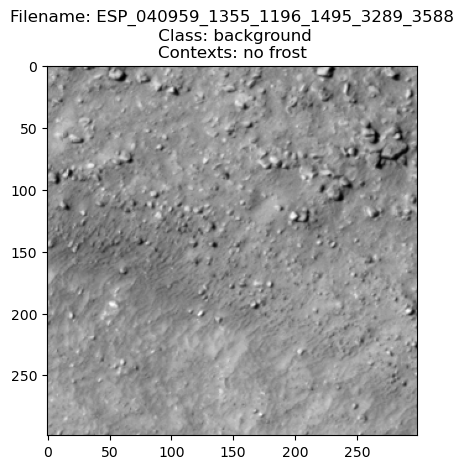

In [8]:
import matplotlib.pyplot as plt
import random

def display_random_image_and_json(some_data):
    # Pick a random image that has frost
    idx = random.choice(range(len(some_data)))
    tile_i = random.choice(range(len(some_data[idx]['tiles'])))
    img_dict = some_data[idx]['tiles'][tile_i]

    img = img_dict['tile']

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Set the title
    ax.set_title(
        f"Filename: {img_dict['file']}\n Class: {img_dict['class']}\nContexts: {decode_array_to_context(img_dict['frost_types'])}")

    plt.show()


display_random_image_and_json(train_data)


## Preprocess data

Gather and bin the data

In [23]:
# frost type categories = [defrosting marks, halos, polygonal cracks, slab ice cracks, uniform albedo, other]

# Train Data
X_train = []
y_train = []
for i in range(len(train_data)):
    for j in range(len(train_data[i]['tiles'])):
        X_train.append(train_data[i]['tiles'][j]['tile'])
        y_train.append(int(train_data[i]['tiles'][j]['class'] == "frost"))

# Validate Data
X_val = []
y_val = []
for i in range(len(validate_data)):
    for j in range(len(validate_data[i]['tiles'])):
        X_val.append(validate_data[i]['tiles'][j]['tile'])
        y_val.append(int(validate_data[i]['tiles'][j]['class'] == "frost"))

# Test Data
X_test = []
y_test = []
for i in range(len(test_data)):
    for j in range(len(test_data[i]['tiles'])):
        X_test.append(test_data[i]['tiles'][j]['tile'])
        y_test.append(int(test_data[i]['tiles'][j]['class'] == "frost"))

Format the data

In [24]:
# Convert lists to numpy array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

###### Shuffle the training set ######
indices = np.arange(X_train.shape[0])

# First shuffle the indices
np.random.shuffle(indices)

# Then use the shuffled indices to shuffle data and labels
X_train = X_train[indices]
y_train = y_train[indices]

In [25]:
frost_count = 0
for item in y_train:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_train))}%) are frost out of {len(y_train)} in the training set")

496 (50.871794871794876%) are frost out of 975 in the training set


In [26]:
frost_count = 0
for item in y_val:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_val))}%) are frost out of {len(y_val)} in the validation set")

190 (34.54545454545455%) are frost out of 550 in the validation set


In [27]:
frost_count = 0
for item in y_test:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_test))}%) are frost out of {len(y_test)} in the validation set")

270 (48.64864864864865%) are frost out of 555 in the validation set


Make sure it's formatted correctly

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(975, 299, 299, 3)
(975,)
(550, 299, 299, 3)
(550,)
(555, 299, 299, 3)
(555,)


## Import Tensorflow Packages

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## Weigh classes appropriately

In [30]:
from sklearn.utils.class_weight import compute_sample_weight

weights = compute_sample_weight(class_weight='balanced', y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))

## Fine Tune InceptionV3

In [43]:
base_model = InceptionV3(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

## Add additional layers

In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Let's add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer for regularization

# Let's add another fully connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer for regularization

# And one final layer to output the prediction
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [50]:
# Let's say you want a learning rate of 0.001
opt = Adam(learning_rate=0.007)

# Then compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
batch_size = 15
epochs = 100

Give this roughly 2 minutes to run

In [56]:
# Assuming you already have the corresponding labels in y_train, y_val, y_test
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    shuffle=True)

validation_generator = valid_datagen.flow(
    X_val,
    y_val,
    batch_size=batch_size,
    shuffle=True)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=1,
    shuffle=False)

## Train the model

In [57]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
max_steps = len(X_train) // batch_size
steps = max_steps // 2

history = model.fit(
    train_generator,
    steps_per_epoch = steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = steps,
    class_weight=class_weights)

Epoch 1/100
 1/32 [..............................] - ETA: 2s - loss: 0.1033 - accuracy: 0.9333

2023-07-26 15:24:29.119050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 2s 69ms/step - loss: 0.1566 - accuracy: 0.9438 - val_loss: 2.5412 - val_accuracy: 0.7417
Epoch 2/100
32/32 [==============================] - 2s 64ms/step - loss: 0.1612 - accuracy: 0.9375 - val_loss: 3.1857 - val_accuracy: 0.6729
Epoch 3/100
32/32 [==============================] - 2s 66ms/step - loss: 0.1454 - accuracy: 0.9542 - val_loss: 1.9960 - val_accuracy: 0.7812
Epoch 4/100
32/32 [==============================] - 2s 70ms/step - loss: 0.2547 - accuracy: 0.9312 - val_loss: 1.9326 - val_accuracy: 0.7833
Epoch 5/100
32/32 [==============================] - 2s 70ms/step - loss: 0.1633 - accuracy: 0.9396 - val_loss: 1.6355 - val_accuracy: 0.8104
Epoch 6/100
32/32 [==============================] - 2s 65ms/step - loss: 0.1019 - accuracy: 0.9521 - val_loss: 2.5782 - val_accuracy: 0.7708
Epoch 7/100
32/32 [==============================] - 2s 68ms/step - loss: 0.1407 - accuracy: 0.9708 - val_loss: 3.0846 - val_accuracy: 0.7854
Epoch 8/100
32/32 

KeyboardInterrupt: 

## Save the weights as a .h5 file
Also save the history of the model as a .csv file

In [ ]:
import pandas as pd
model.save('inception_b5.h5')
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = 'inception_b5.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate the model
Using our custom metrics. Load in the file.

In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model

# Register the custom metric function
my_model = load_model('inception_b5.h5')

my_model_history = pd.read_csv(
    'inception_b5.csv')


In [ ]:
predictions = my_model.predict(X_test)

18/18 [==============================] - 3s 77ms/step


In [ ]:
from sklearn.metrics import accuracy_score

# Convert predictions to binary format
predictions_binary = (predictions >= 0.5).astype(int)

# Calculate accuracy
acc = accuracy_score(y_test, predictions_binary)

In [ ]:
print(f"Testing accuracy: {acc}")

Testing accuracy: 0.43963963963963965


In [ ]:
frost_count = 0
for item in y_test:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_test))}%) are frost out of {len(y_test)}")

pred_frost_count = 0
for i in range(500, len(y_test)):
    pred_frost_count += predictions_binary[i][0]

print(f"Predicted {pred_frost_count} were frost")

270 (48.64864864864865%) are frost out of 555
Predicted 52 were frost
